# Model Validation: How to Know How Much Your Model Knows

- Matthew Emery - Senior Data Scientist @ [Imbellus Inc.](https://www.imbellus.com/#/)
- www.matthewemery.ca
- Find the code at https://github.com/lstmemery/lunch-and-learn-validation

## What Are We Covering?

 1. A quick explainer on Fashion MNIST and Decision Trees
 2. Overfitting Explanation
 3. The Golden Rule of Machine Learning
 4. Optimization Bias and Cross-Validation

In [1]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import gzip
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from math import log, sqrt
from pathlib import Path
import numpy as np
import bokeh.plotting as bk
import graphviz

fmnist_class_names = ["T-shirt", "Trouser", "Pullover", "Dress", "Coat",
                    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

%matplotlib notebook

In [2]:
with gzip.open(Path("data", "train-labels-idx1-ubyte.gz")) as label_path:
    labels = np.frombuffer(label_path.read(), dtype=np.uint8,
                           offset=8)

with gzip.open(Path("data", "train-images-idx3-ubyte.gz")) as image_path:
    features = np.frombuffer(image_path.read(), 
                           dtype=np.uint8, 
                           offset=16).reshape(len(labels), 784)
    

<Figure size 432x288 with 0 Axes>

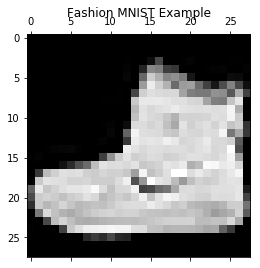

In [3]:
plt.gray()
plt.matshow(features[0].reshape((28,28))) 
plt.title("Fashion MNIST Example")
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

- When I first wrote this tutorial, I used MNIST
- Then I found out about Fashion MNIST
- Benefits:
    1. Harder than MNIST
    2. Less used than MNIST
    3. Better represents modern computer vision tasks
- How many of you have heard of MNIST?


## A Quick Explainer on Decision Trees

![](img/decision_tree.png)

- A decision tree is trained by looking at each pixel value and seeing what breakpoint would split classes the best
- Pick the best pixel to split on and continue
- The size of the tree is a hyperparameter
- I decided to choose a decision tree to illustrate this for a couple of reasons
  1. Decision Trees are easy to understand
  2. No need to do any preprocessing
  3. It shows that even simple models can do simple computer vision tasks

## Train Test Split

<img src="img/splitting-data.jpg" alt="https://www.includehelp.com/ml-ai/data-splitting.aspx" width="20%" height="20%" class="center">

In [4]:
(train_features, validation_features,
 train_labels, validation_labels) = train_test_split(
    features,
    labels,
    random_state=0,
    shuffle=True,
    test_size=0.20, # This is fine enough
    stratify=labels
)

- This is the core way we evaluate models
- If we train on one dataset, how well does it do on the holdout?
- Always set a seed so you can compare 
- Test size is traditionally 80/20 - this mostly folklore though
- Do not shuffle if you are dealing with time series
- Stratification is essential when you are dealing with unbalanced labels

In [5]:
models, train_scores = [], []

for depth in range(1, 20):
    model = DecisionTreeClassifier(max_depth=depth, random_state=0)
    model.fit(train_features, train_labels)
    
    score = model.score(train_features, train_labels)
    print("Depth:", depth, "Training Accuracy:", round(score, 2))
    models.append(model); train_scores.append(score)

Depth: 1 Training Accuracy: 0.2
Depth: 2 Training Accuracy: 0.36
Depth: 3 Training Accuracy: 0.5
Depth: 4 Training Accuracy: 0.65
Depth: 5 Training Accuracy: 0.71
Depth: 6 Training Accuracy: 0.74
Depth: 7 Training Accuracy: 0.78
Depth: 8 Training Accuracy: 0.81
Depth: 9 Training Accuracy: 0.83
Depth: 10 Training Accuracy: 0.85
Depth: 11 Training Accuracy: 0.87
Depth: 12 Training Accuracy: 0.89
Depth: 13 Training Accuracy: 0.91
Depth: 14 Training Accuracy: 0.93
Depth: 15 Training Accuracy: 0.94
Depth: 16 Training Accuracy: 0.96
Depth: 17 Training Accuracy: 0.97
Depth: 18 Training Accuracy: 0.98
Depth: 19 Training Accuracy: 0.98


In [6]:
# This is how the first Decision Tree Illustration Was Made
graph_data = export_graphviz(models[1],
                            filled=True,
                            rounded=True,
                            class_names=fmnist_class_names)
graph = graphviz.Source(graph_data, format="png")
graph.render("decision_tree", "img")

'img/decision_tree.png'

In [7]:
validation_scores = []

for depth, model in enumerate(models):
    score = model.score(validation_features, validation_labels)
    print("Depth:", depth, "Validation Accuracy:", round(score, 2))
    validation_scores.append(score)

Depth: 0 Validation Accuracy: 0.2
Depth: 1 Validation Accuracy: 0.36
Depth: 2 Validation Accuracy: 0.5
Depth: 3 Validation Accuracy: 0.65
Depth: 4 Validation Accuracy: 0.71
Depth: 5 Validation Accuracy: 0.73
Depth: 6 Validation Accuracy: 0.76
Depth: 7 Validation Accuracy: 0.78
Depth: 8 Validation Accuracy: 0.8
Depth: 9 Validation Accuracy: 0.81
Depth: 10 Validation Accuracy: 0.81
Depth: 11 Validation Accuracy: 0.81
Depth: 12 Validation Accuracy: 0.82
Depth: 13 Validation Accuracy: 0.81
Depth: 14 Validation Accuracy: 0.81
Depth: 15 Validation Accuracy: 0.81
Depth: 16 Validation Accuracy: 0.81
Depth: 17 Validation Accuracy: 0.81
Depth: 18 Validation Accuracy: 0.8


In [8]:
plot_1 = bk.figure(title="Training vs. Validation Accuracy",
    )
plot_1.xaxis.axis_label = "Depth"
plot_1.yaxis.axis_label = "Accruacy"
plot_1.line(x = range(1, 20), y = train_scores, 
            line_width = 5, color = "blue", legend = "Training Accuracy")
plot_1.line(x = range(1, 20), y = validation_scores, 
            line_width = 5, color = "orange", legend = "Validation Accuracy")
bk.show(plot_1)

![](img/bokeh_plot.png)

 - If you want to show Bokeh plots inline you need

`jupyter labextension install jupyterlab_bokeh`

## Overfitting

- The gap between training and validation accuracy is **overfitting**
 - **Interpretation**: Our model has memorized part of the data set instead of learning the underlying rules
 - If the validation accuracy was higher than our training that's **underfitting**

## Think About Studying for an Exam

- Training your model is like the model reviewing its notes
- Validating your model is when you take the midterm
- Deploying your model is the final

## Golden Rule of Machine Learning:

# The test cannot influence training in any way

- If you know the answers on the exam ahead of time, you won't know if you actually learned the material

## Common Mistakes

 - Time Series: Incorporating information from the future in your model (i.e., quarterly results before end-of-quarter)
 - Imputing based on the combined train-test dataset
 - Taking a peek on the test data halfway through training your model

## Should I Just Fit a Million Models Until I Find Something?

# No!

## An Illustration


 - Sign up for my service, and I'll email you a prediction of whether or not the S&P 500 goes up or down that morning
 - Every work day for two weeks I'm right
 - **What do you need to ask me before you should trust my model?**

## How Many Other People Did I Send Emails To?

- Two business weeks is 10 business days
$$2^{10} = 1024$$
- If I sent 1024 people different emails (Up, Down, Up, etc.) I'm guaranteed to be right once

## The Same Thing Happens with Machine Learning Models

 - We call this **optimization bias**
 - Sometimes you find something that fits your validation data set through dumb luck

## How Do We Decrease the Effect of Optimization Bias?

- **Cross-validation** (or repeated cross-validation)
- Leave a **test set** that you evaluate very rarely (once a week or less)
- Set a limit to the number of models you will evaluate

## Cross-Validation

![https://bradleyboehmke.github.io/hands-on-machine-learning-with-r/regression-performance.html](img/cross-validation.png)

In [9]:
cv_scores = []
for depth in range(1, 20):
    model = DecisionTreeClassifier(
        max_depth=depth,
    random_state=0)
    
    cv_score = cross_val_score(
        model,
        features,
        labels,
        cv = 5,
        n_jobs = -1
    )
    
    print("Depth:", depth,
          "Mean:", round(np.mean(cv_score), 2), 
          "SD:", round(np.std(cv_score), 3))
    
    cv_scores.append(cv_score)

Depth: 1 Mean: 0.2 SD: 0.0
Depth: 2 Mean: 0.36 SD: 0.002
Depth: 3 Mean: 0.5 SD: 0.003
Depth: 4 Mean: 0.65 SD: 0.002
Depth: 5 Mean: 0.71 SD: 0.003
Depth: 6 Mean: 0.73 SD: 0.003
Depth: 7 Mean: 0.76 SD: 0.003
Depth: 8 Mean: 0.79 SD: 0.002
Depth: 9 Mean: 0.8 SD: 0.002
Depth: 10 Mean: 0.81 SD: 0.003
Depth: 11 Mean: 0.81 SD: 0.004
Depth: 12 Mean: 0.81 SD: 0.003
Depth: 13 Mean: 0.81 SD: 0.003
Depth: 14 Mean: 0.81 SD: 0.002
Depth: 15 Mean: 0.81 SD: 0.003
Depth: 16 Mean: 0.81 SD: 0.004
Depth: 17 Mean: 0.81 SD: 0.004
Depth: 18 Mean: 0.81 SD: 0.004
Depth: 19 Mean: 0.81 SD: 0.005


In [10]:
plot_2 = plot_1

plot_2.line(x = range(1, 20), y = np.mean(cv_scores, axis=-1), 
            line_width = 5, color = "purple", legend = "Cross Validation Accuracy")
bk.show(plot_2)

![](img/bokeh_plot_cv.png)

- Notice that this doesn't change much
- This is because we already have sufficient data to get an accurate result
- Try this on a smaller dataset
- This is good news, cross-validation takes longer than validation

## Summary

 - Always create a validation set (cross-validation if you have a small amount of data)
 - Never let information from your validation set leak into to your training
 - Don't train models for no reason

## Bibliography


[1] “Data splitting | Machine Learning.” [Online]. Available: https://www.includehelp.com/ml-ai/data-splitting.aspx. [Accessed: 17-Mar-2019].

[2]“1.10. Decision Trees — scikit-learn 0.20.3 documentation.” [Online]. Available: https://scikit-learn.org/stable/modules/tree.html#tree. [Accessed: 17-Mar-2019].

[3]M. Schmidt, “DSCI 573: Model Selection and Feature Selection 1.”

[4]T. Sarkar, “How to analyze ‘Learning’: Short tour of computational learning theory,” Towards Data Science, 26-Oct-2018. [Online]. Available: https://towardsdatascience.com/how-to-analyze-learning-short-tour-of-computational-learning-theory-9d93b15fc3e5. [Accessed: 03-Mar-2019].

[5]A MNIST-like fashion product database. Benchmark :point_right: : zalandoresearch/fashion-mnist. Zalando Research, 2019.

[6]I. Guyon and T. B. Laboratories, “A scaling law for the validation-set training-set size ratio,” p. 11.